In [74]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, to_dense_adj, to_networkx
import sys
#add path to utils
sys.path.append('../../')
from utils import GraphDataset, reconstruct_matrix
from networks.graph_vae import GRAPH_VAE
from networks.graph_vae_v2 import GRAPH_VAE_V2
from networks.gae import GRAPH_VAE_V3
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import argparse
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.utils import negative_sampling
import itertools
import matplotlib.colors as mcolors
import random
from torch_geometric.utils.convert import from_networkx

In [30]:
dataset = GraphDataset(root='../../../data/sub20/graphs')

In [31]:
# Define the parameters
params = {
    'distribution_std': 0.1,
    'variational_beta': 0.01,
    'capacity': 128,
}

In [32]:
input_dim = dataset.num_features
latent_dim = 32
model = GRAPH_VAE_V3(input_dim, latent_dim, params).to("cuda")
# Load weights
model.load_state_dict(torch.load(f"../../networks/weights/GRAPH_VAE_V3_latent=32_lr=0.0001_epochs=10_variational_beta=0.01_capacity=128.pt"))

/tmp/ipykernel_28177/1063172386.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../../networks/weights/GRAPH_VAE_V3_latent=32_lr=0.000

<All keys matched successfully>

In [33]:
# Create the DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [94]:
model.eval()
for i, batch in enumerate(loader):
    batch = batch.to("cuda")
    output, mu, log = model(batch.x, batch.edge_index, batch.batch)
    if batch.x.shape[0] < 30 and batch.x.shape[0] > 25:
        print(batch.x.shape)
        break

torch.Size([26, 1])


In [97]:
batch

DataBatch(edge_index=[2, 25], original_ids=[26], weight=[25], num_nodes=26, original_graph=[1], x=[26, 1], batch=[26], ptr=[2])

In [98]:
batch.original_ids

tensor([181, 180, 200, 220, 201, 221, 242, 222, 261, 202, 262, 260, 243, 223,
        281, 263, 280, 283, 203, 302, 182, 303, 301, 264, 244, 284],
       device='cuda:0', dtype=torch.int32)

In [99]:
current_edges_set = set(map(tuple, batch.original_ids[batch.edge_index].t().tolist()))
all_edges_set = set(map(tuple, model.grid_edges))
# Find edges in all_possible_edges that are not in current edges
missing_edges_set = all_edges_set - current_edges_set

missing_edges = random.choices(list(missing_edges_set), k=batch.edge_index.shape[1])
# Convert back to edge_index format
missing_edges = torch.tensor(list(missing_edges), dtype=torch.long).t()

In [101]:
missing_edges_ = [(missing_edges[0][i], missing_edges[1][i]) for i in range(missing_edges.shape[1])]

In [102]:
G = nx.DiGraph()
G.add_edges_from(missing_edges_)

In [103]:
pyg_graph = from_networkx(G)
pyg_graph.x = torch.tensor([1 for _ in range(len(G))], dtype=torch.float).unsqueeze(1)

In [104]:
output_neg, _, _ = model(pyg_graph.x.cuda(), pyg_graph.edge_index.cuda(), torch.Tensor([0]))

In [105]:
output_neg

tensor([0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126,
        0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126,
        0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126, 0.3126],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [106]:
edges = batch.edge_index[:,output >= 0.5]
neg_edges = pyg_graph.edge_index.cuda()[:,output_neg >= 0.5]
# concat both tensors
all_edges = torch.cat((edges, neg_edges), dim=1)
adj = to_dense_adj(all_edges).squeeze(0).cpu().numpy()
G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
# Delete isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

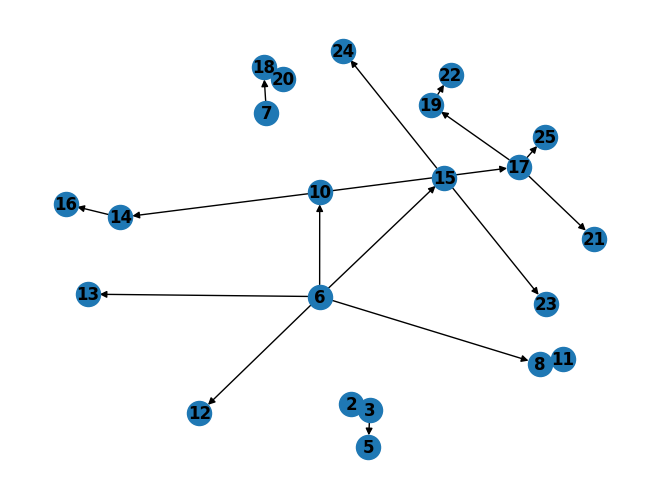

In [107]:
# draw graph
pos = nx.spring_layout(G)
nx.draw(G, pos, font_weight='bold', labels={node: node for node in G.nodes()}, with_labels=True)
plt.show()

In [108]:
1 - (output_neg >= 0.5).sum() / output_neg.shape[0]

tensor(1., device='cuda:0')

In [109]:
(output >= 0.5).sum() / output.shape[0]

tensor(0.7600, device='cuda:0')

In [112]:
# reconstruct graph:
edges = batch.edge_index[:,output >= 0.5]
edges = torch.Tensor([[batch.original_ids[edges[0][i]], batch.original_ids[edges[1][i]]] for i in range(edges.shape[1])]).t().long().cuda()    
neg_edges = pyg_graph.edge_index.cuda()[:,output_neg >= 0.5]
# concat both tensors
all_edges = torch.cat((edges, neg_edges), dim=1)
adj = to_dense_adj(all_edges).squeeze(0).cpu().numpy()
G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
# Delete isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))
# translate batch.edge_index labels based on batch.original_ids
edge_index = [[], []]
for i in range(batch.edge_index.shape[1]):
    edge_index[0].append(batch.original_ids[batch.edge_index[0][i]])
    edge_index[1].append(batch.original_ids[batch.edge_index[1][i]])
# turn into tensor int64
edge_index = torch.tensor(edge_index, dtype=torch.int64)
adj_real = to_dense_adj(edge_index).squeeze(0).cpu().numpy()

G_real = nx.from_numpy_array(adj_real, create_using=nx.DiGraph)

# Find edges that are in one graph but not the other
edges_G = set(G.edges())
edges_G_real = set(G_real.edges())

unique_to_G = edges_G - edges_G_real
unique_to_G_real = edges_G_real - edges_G

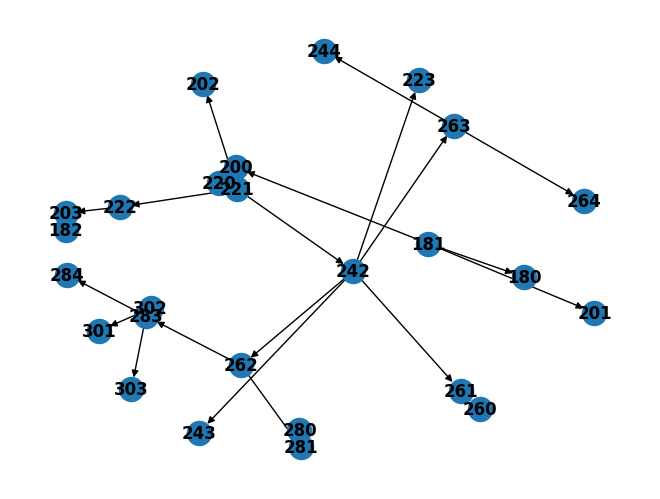

In [113]:
# draw graph
# drop unconnected nodes
G_real.remove_nodes_from(list(nx.isolates(G_real)))
pos = nx.spring_layout(G_real)
# draw with labels
nx.draw(G_real, pos, font_weight='bold', labels={node: str(node) for node in G_real.nodes()})
plt.show()

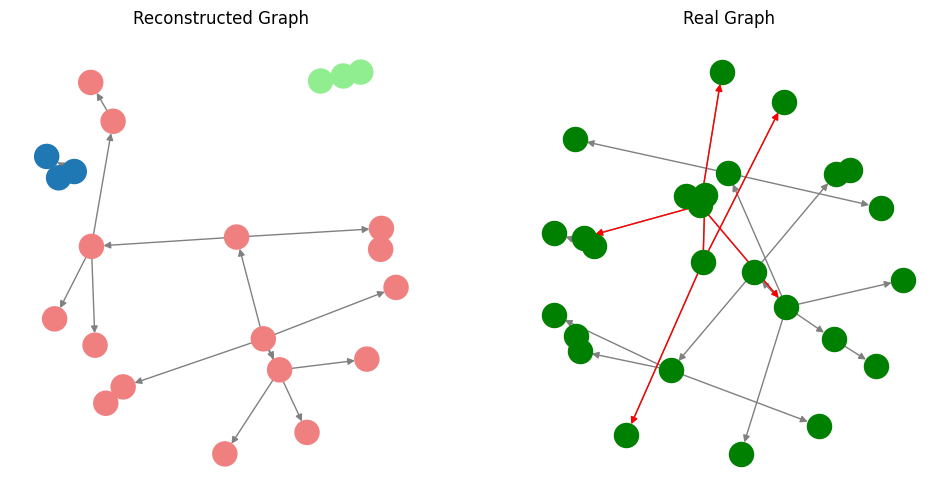

In [114]:
# Find connected components in the reconstructed graph
components = list(nx.weakly_connected_components(G))
colors = itertools.cycle(['#1f78b4', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow'])

# Assign a color to each node based on its component
node_colors = {}
for component, color in zip(components, colors):
    for node in component:
        node_colors[node] = color

# Plotting the graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the reconstructed graph
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=axes[0], with_labels=False, node_color=[node_colors[node] for node in G.nodes()], edge_color='gray')
if unique_to_G:
    nx.draw_networkx_edges(G, pos, edgelist=unique_to_G, edge_color='red', ax=axes[0])
axes[0].set_title('Reconstructed Graph')

# Plot the real graph
pos_real = nx.spring_layout(G_real)
G_real.remove_nodes_from(list(nx.isolates(G_real)))
nx.draw(G_real, pos_real, ax=axes[1], with_labels=False, node_color='green', edge_color='gray')
if unique_to_G_real:
    nx.draw_networkx_edges(G_real, pos_real, edgelist=unique_to_G_real, edge_color='red', ax=axes[1])
axes[1].set_title('Real Graph')

plt.show()

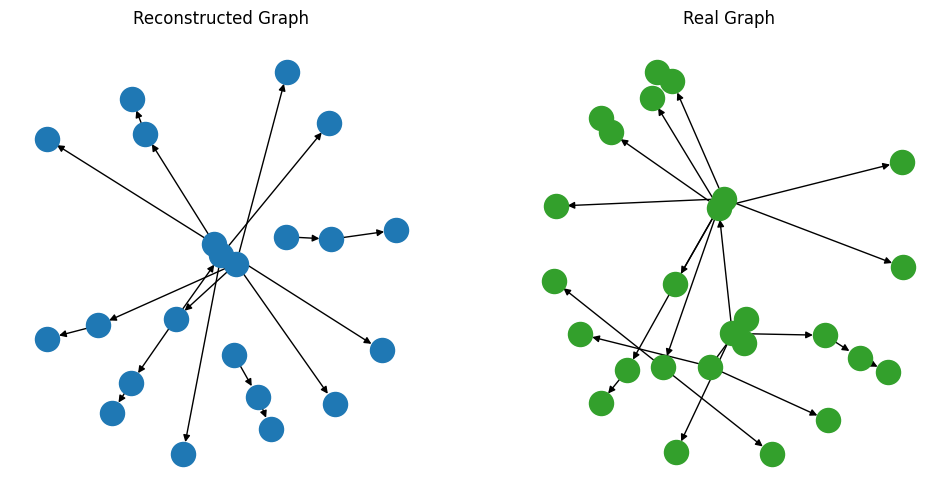

In [115]:
# Plotting the graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the reconstructed graph using the default layout
nx.draw(G, ax=axes[0], with_labels=False, node_color='#1f78b4', edge_color='black')  # Blue color
axes[0].set_title('Reconstructed Graph')

# Plot the real graph using the default layout
nx.draw(G_real, ax=axes[1], with_labels=False, node_color='#33a02c', edge_color='black')  # Green color
axes[1].set_title('Real Graph')

plt.show()

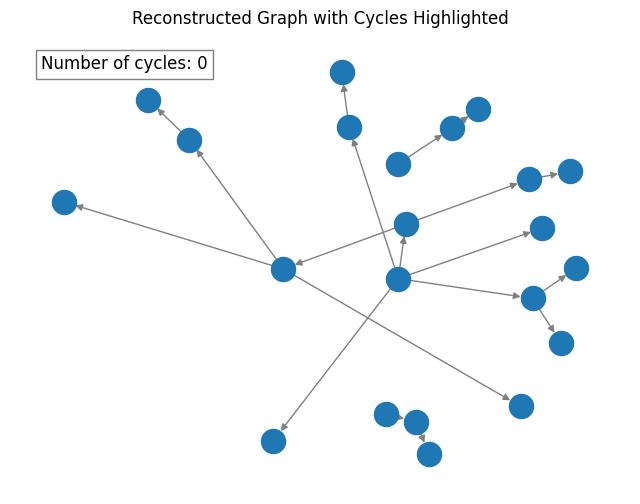

In [116]:
# Find cycles in the reconstructed graph
cycles = list(nx.simple_cycles(G))

# Generate a list of unique colors
num_cycles = len(cycles)
colors = list(mcolors.CSS4_COLORS.values())[:num_cycles]

# Extract edges that are part of cycles and assign different colors
cycle_edges = []
for cycle, color in zip(cycles, colors):
    cycle_edges.append(([(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))], color))

# Plotting the graph
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the reconstructed graph
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax, node_color='#1f78b4', edge_color='gray')

# Highlight each cycle with a different color
for edges, color in cycle_edges:
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2.0, ax=ax)

# Add the number of cycles as a label
ax.text(0.05, 0.95, f'Number of cycles: {num_cycles}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

ax.set_title('Reconstructed Graph with Cycles Highlighted')

plt.show()